In [1]:
import state_space_system
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import numpy as np
from casadi import *

from control.matlab import *
import control 

from ERA import *
from kalman_filter import *
from utils_optimization_problem import *

mpl.rcParams['font.size'] = 16 # set the matplotlib parameter

## 1. System Identification ##

In [2]:
## system identification ##

q = 2   # Number of inputs
p = 3   # Number of outputs
r = 10  # Reduced model order

time = np.linspace(0, 20, num=500)
sys = state_space_system.sys()# import real system
sys.reset()
u = np.zeros((time.shape[0]-1, 2))
u[0,0] = 1
u1 = u

u = np.zeros((time.shape[0]-1, 2))
u[0,1] = 1
u2 = u

re = 10 # repeated time for measurement
y_1 = np.zeros((time.shape[0],3))
y_2 = np.zeros((time.shape[0],3))
for n in range(re):
    y_1_t = sys.simulate(time, u1)
    # Concatenate:
    y_1_t = np.array(y_1_t)
    y_1 += y_1_t

    y_2_t = sys.simulate(time, u2)
    # Concatenate:
    y_2_t = np.array(y_2_t)
    y_2 += y_2_t
y_1 /= re
y_2 /= re
    
yFull = np.zeros((time.shape[0],p,q))

yFull[:,:,0] = y_1[:,:]
yFull[:,:,1] = y_2[:,:]

YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m 

# Compute reduced order model from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)

# simulate the ERA system by using control package
sysERA = ss(Ar,Br,Cr,Dr,1)
y = np.zeros((time.shape[0],p,q))
for qi in range(q):
    y[:,:,qi],t = impulse(sysERA,np.arange(time.shape[0]),input=qi)

Text(0.5, 1.0, 'third mass')

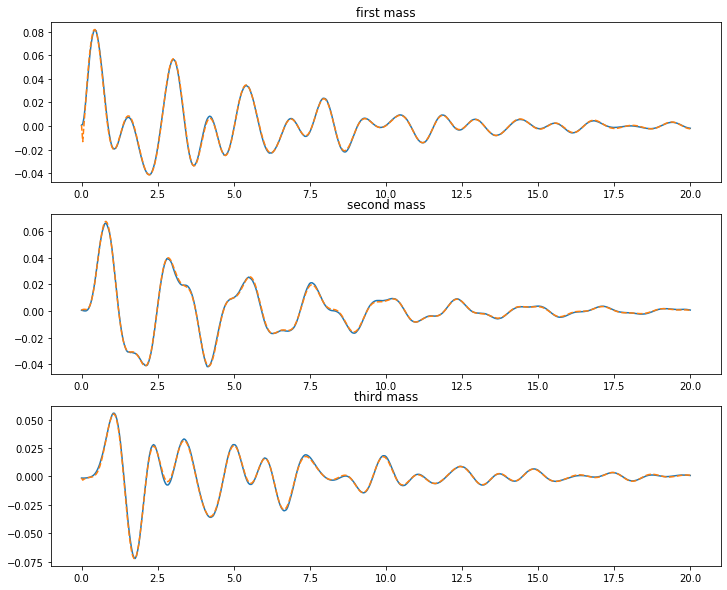

In [3]:
## ident sys. and original sys. ##
fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(12,10))
ax1.plot(time, y_1[:,0])
ax1.plot(time, y[:,0,0], '--')
ax1.set_title('first mass')
ax2.plot(time, y_1[:,1])
ax2.plot(time, y[:,1,0], '--')
ax2.set_title('second mass')
ax3.plot(time, y_1[:,2])
ax3.plot(time, y[:,2,0], '--')
ax3.set_title('third mass')

In [4]:
## Augmented system ##
Ab,Bb,Cb = augmented_system(Ar,Br,Cr)

nx = Ab.shape[1] #set the number of state and the control inputs
nu = Bb.shape[1]
ny = Cb.shape[0]

## 2. simutaneous approach ##

In [39]:
## create a symbolic expression of state space ##
x = SX.sym("x",nx,1)
delta_u = SX.sym("delta_u",nu,1)

x_next = Ab@x + Bb@delta_u
system = Function("sys",[x,delta_u],[x_next]) # Create the CasADi function

In [40]:
## MPC initialization and casadi objective function ##

Q = 30                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 5                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 15                     # horizon

y_Ref = SX.sym("y_ref",ny,1)   # desired trajectory

# state cost
stage_cost = (y_Ref-Cb@x).T@Q@(y_Ref-Cb@x)+ delta_u.T@R@delta_u
stage_cost_fcn = Function('stage_cost',[x,delta_u,y_Ref],[stage_cost])

# terminal cost
terminal_cost = (y_Ref-Cb@x).T@S@(y_Ref-Cb@x)
terminal_cost_fcn = Function('terminal_cost',[x,y_Ref],[terminal_cost])

In [41]:
#Q[2,2] = 0
#S[2,2] = 0

In [42]:
# state constraints
lb_x = -10*np.ones((nx,1))
ub_x = 10*np.ones((nx,1))
# the last two state variables is actually the control inputs
lb_x[nx-nu:] = -5
ub_x[nx-nu:] = 5
# delta_u changing rate per step constraints
lb_u = -2*np.ones((nu,1))
ub_u = 2*np.ones((nu,1))

In [43]:
## create optimization problem ##
def casadi_setting(reference_signal,nx,nu): # reference_signal:3*15 output*horizon
    
    X = SX.sym("X",(N+1)*nx,1)
    delta_U = SX.sym("U",N*nu,1)

    J = 0
    lb_X = [] # lower bound for X.
    ub_X = [] # upper bound for X
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U
    g = []    # constraint expression g
    lb_g = []  # lower bound for constraint expression g
    ub_g = []  # upper bound for constraint expression g
    
    for k in range(N):
        # 01 
        x_k = X[k*nx:(k+1)*nx,:]
        x_k_next = X[(k+1)*nx:(k+2)*nx,:]
        u_k = delta_U[k*nu:(k+1)*nu,:]
        # 01

        # 02 
        # objective
        J += stage_cost_fcn(x_k,u_k,reference_signal[k])
        # 02

        # 03 
        # equality constraints (system equation)
        x_k_next_calc = system(x_k,u_k)
        # 03

        # 04
        g.append(x_k_next - x_k_next_calc)
        lb_g.append(np.zeros((nx,1)))
        ub_g.append(np.zeros((nx,1)))
        # 04

        # 05
        lb_X.append(lb_x)
        ub_X.append(ub_x)
        lb_U.append(lb_u)
        ub_U.append(ub_u)
        # 05


    x_terminal = X[N*nx:(N+1)*nx,:]
    J += terminal_cost_fcn(x_terminal,reference_signal[-1])
    lb_X.append(lb_x)
    ub_X.append(ub_x)
    return lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J



This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

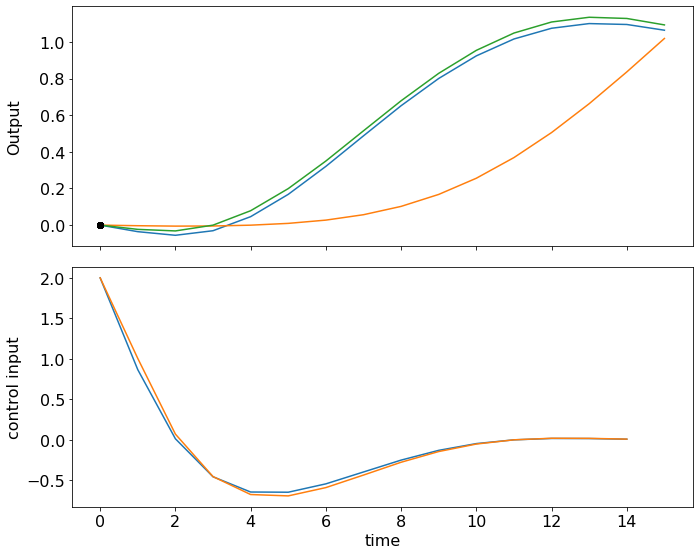

In [44]:
## test the functional solver production ##
reference = np.ones((N,ny))
lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J = casadi_setting(reference,nx,nu)
# Casadi solver
lbx = vertcat(*lb_X, *lb_U)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(X,delta_U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)

prob = {'f':J,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

x_0 = np.zeros((nx,1))

lbx[:nx]=x_0
ubx[:nx]=x_0

res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
delta_U = res['x'][(N+1)*nx:].full().reshape(N, nu)
Y = np.zeros((ny,1))

for n in range(N):
    temp = X[n+1].reshape(nx,1)
    Y = np.hstack((Y,Cb@temp))
    

# visulization of the result
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(Y.T)
ax[1].plot(delta_U)
ax[0].set_ylabel('Output')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

## test result looks pretty good

In [45]:
N_sim = 500 # total simulation step
#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+13))
#################################### reference change test

In [52]:
## MPC main loop ##
x_0 = np.zeros((nx,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])

X = []

for i in range(N_sim-1):
    
    reference = REFERENCE[:,i:i+N]
    
    lb_X,lb_U,ub_X,ub_U,X,delta_U,lb_g,ub_g,g,J = casadi_setting(reference.T,nx,nu)
    
    # Casadi solver
    lbx = vertcat(*lb_X, *lb_U)
    ubx = vertcat(*ub_X, *ub_U)
    x = vertcat(X,delta_U)
    g = vertcat(*g)
    lbg = vertcat(*lb_g)
    ubg = vertcat(*ub_g)

    prob = {'f':J,'x':x,'g':g}
    solver = nlpsol('solver','ipopt',prob)
    
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    
    # solving the optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    delta_u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:].full()
    
    X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
    u_st = X[0,10:].reshape(nu,1)+ delta_u_k
    res_u.append(u_st)
    # simulate the system
    sys.simulate(time[i:i+2], (np.array(u_st)).reshape(1,2))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (np.array(delta_u_k)).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    
    res_x.append(x_next)
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3585096e+003 4.43e+000 1.11e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   2 1.0087165e+000 1.78e-015 2.56e-002  -1.0 9.75e-001    -  9.56e-001 1.00e+000f  1
   3 8.5935157e-001 3.55e-015 8.17e-015  -1.7 4.69e-001    -  1.00e+000 1.00e+000f  1
   4 8.5803779e-001 2.66e-015 8.82e-015  -2.5 4.62e-002    -  1.00e+000 1.00e+000f  1
   5 8.5803473e-001 3.55e-015 8.64e-015  -3.8 2.20e-003    -  1.00e+000 1.00e+000f  1
   6 8.5803473e-001 3.55e-015 6.64e-015  -5.7 9.99e-005    -  1.00e+000 1.00e+000h  1
   7 8.5803473e-001 3.55e-015 1.16e-014  -8.6 1.22e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.5803472888256038e-001   8.5803472888256038e-001
Dual infeasibility......:  1.1621862804186552e-014   1.1621862804186552e-014
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5063141015833849e-009   2.5063141015833849e-009
Overall NLP error.......:  2.5063141015833849e-009   2.5063141015833849e-00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   7 9.8660807e-001 2.66e-015 7.38e-015  -8.6 1.18e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.8660806725444417e-001   9.8660806725444417e-001
Dual infeasibility......:  7.3836283146350824e-015   7.3836283146350824e-015
Constraint violation....:  2.6645352591003757e-015   2.6645352591003757e-015
Complementarity.........:  2.5062942685400703e-009   2.5062942685400703e-009
Overall NLP error.......:  2.5062942685400703e-009   2.5062942685400703e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500427e+003 4.32e+000 1.11e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500537e+003 4.34e+000 1.11e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   5 7.2758291e-001 3.55e-015 8.55e-015  -3.8 2.21e-003    -  1.00e+000 1.00e+000f  1
   6 7.2758290e-001 3.55e-015 7.35e-015  -5.7 1.01e-004    -  1.00e+000 1.00e+000h  1
   7 7.2758290e-001 3.55e-015 9.08e-015  -8.6 1.23e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.2758289906668161e-001   7.2758289906668161e-001
Dual infeasibility......:  9.0835147283896390e-015   9.0835147283896390e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5063148002394188e-009   2.5063148002394188e-009
Overall NLP error.......:  2.5063148002394188e-009   2.5063148002394188e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constra

   7 7.3433280e-001 2.22e-015 6.62e-015  -8.6 1.22e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.3433280370586862e-001   7.3433280370586862e-001
Dual infeasibility......:  6.6215962618382739e-015   6.6215962618382739e-015
Constraint violation....:  2.2204460492503131e-015   2.2204460492503131e-015
Complementarity.........:  2.5063128851818012e-009   2.5063128851818012e-009
Overall NLP error.......:  2.5063128851818012e-009   2.5063128851818012e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3500508e+003 4.34e+000 1.11e+001  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

   3 8.0623014e-001 4.44e-015 8.29e-015  -1.7 4.63e-001    -  1.00e+000 1.00e+000f  1
   4 8.0497727e-001 2.66e-015 4.79e-015  -2.5 4.51e-002    -  1.00e+000 1.00e+000f  1
   5 8.0497431e-001 1.78e-015 6.08e-015  -3.8 2.16e-003    -  1.00e+000 1.00e+000f  1
   6 8.0497431e-001 2.66e-015 8.82e-015  -5.7 9.88e-005    -  1.00e+000 1.00e+000h  1
   7 8.0497431e-001 3.55e-015 8.20e-015  -8.6 1.21e-006    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  8.0497430752841836e-001   8.0497430752841836e-001
Dual infeasibility......:  8.2000979838118426e-015   8.2000979838118426e-015
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5063050101822433e-009   2.5063050101822433e-009
Overall NLP error.......:  2.5063050101822433e-009   2.5063050101822433e-009


Number of objective function evaluations             = 8
Number of objective gradi

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

Dual infeasibility......:  1.1789746322519130e-014   1.1789746322519130e-014
Constraint violation....:  3.5527136788005009e-015   3.5527136788005009e-015
Complementarity.........:  2.5063106181834486e-009   2.5063106181834486e-009
Overall NLP error.......:  2.5063106181834486e-009   2.5063106181834486e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/o function evaluations)   =      0.023
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (125.00us) 998.00us (124.75us)       

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2218
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      855

Total number of variables............................:      210
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      210
                     variables with only upper bounds:        0
Total number of equality constraints.................:      180
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

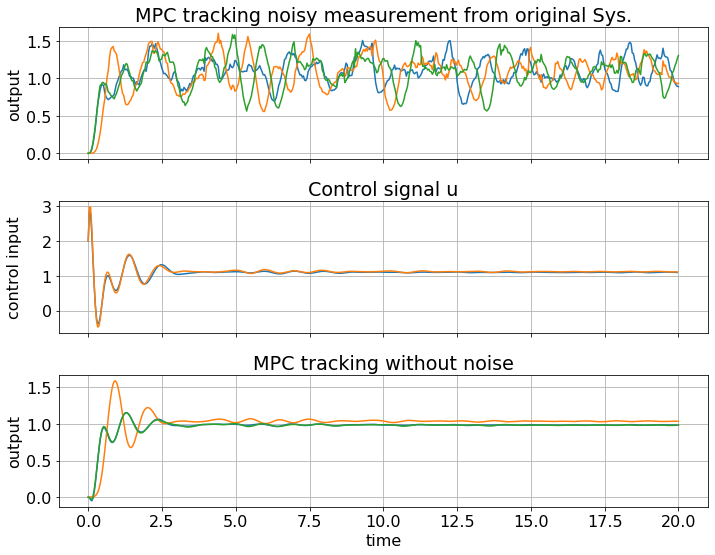

In [53]:
## results visualization ##
time = np.linspace(0, 20, num=500)

res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))
res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1) + (Dr@res_u[n,:]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('Step_response',dpi=250)

## 3. sequential approach ##

In [5]:
def casadi_seq(x0,yref,delta_U,Ab,Bb,Cb,N,Q,R): # yref = (N,ny)  
    # r
    r = yref.reshape(N*ny,1)
    
    # C_dbar
    trr = np.zeros((1,Bb.shape[1]*N))
    for k in range(N):
        fr = np.zeros((Bb.shape[0],Bb.shape[1]*N))
        for i in range(k+1):
            temp_C_dbar = np.linalg.matrix_power(Ab,k-i)@Bb
            fr[:,i*Bb.shape[1]:(i+1)*Bb.shape[1]] = temp_C_dbar
        trr = np.vstack((trr,fr))
    C_dbar = np.delete(trr,0,axis=0)
    
    # A_dachdach
    trr2 = np.zeros((1,Ab.shape[0]))
    for n in range(N):
        temp_A_dachdach = np.linalg.matrix_power(Ab,n+1)
        trr2 = np.vstack((trr2,temp_A_dachdach))
    A_dachdach = np.delete(trr2,0,axis = 0)
    
    # Q_dbar
    trr3 = Cb.T@Q@Cb
    Q_dbar = np.kron(np.eye(N),trr3)
    
    # R_dbar
    R_dbar = np.kron(np.eye(N),R)
    
    # T_dbar
    trr4 = Q@Cb
    T_dbar = np.kron(np.eye(N),trr4)
    
    H_dbar = C_dbar.T@Q_dbar@C_dbar + R_dbar
    F_dbar_T = np.vstack((A_dachdach.T@Q_dbar@C_dbar,-T_dbar@C_dbar))
    
    J = 1/2*(delta_U.T@H_dbar@delta_U) + np.hstack((x0.T,r.T))@F_dbar_T@delta_U
    
    return J

In [30]:
# sequantial approach optimized variables
Q = 30                    # make it larger to get a more aggresive controller
Q = Q*np.diag(np.ones(ny)) # the state cost mutiplyer by using the output channel: ny=3

S = Q # S for terminal cost is equal to Q

R = 5                     # set it to 1, trying to reduce the influence from the control energy term
R = np.diag(R*np.ones(nu)) # the cost of control

N = 50                     # horizon

delta_U = SX.sym("U",N*nu,1)

In [31]:
# input constraints
lb_u = -10*np.ones((nu,1))
ub_u = 10*np.ones((nu,1))

In [32]:
yref = 1*np.ones((N,ny))

x0 = np.zeros((nx,1))

J = casadi_seq(x0,yref,delta_U,Ab,Bb,Cb,N,Q,R)

cost_func = Function('stage_cost',[delta_U],[J])

In [33]:
lb_U = [] # lower bound for delta_U
ub_U = [] # upper bound for delta_U

for k in range(N):
    
    lb_U.append(lb_u)
    ub_U.append(ub_u)
    
A = cost_func(delta_U)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

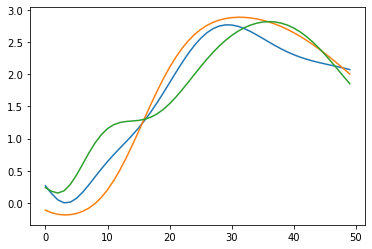

In [34]:
lbx = vertcat(*lb_U)
ubx = vertcat(*ub_U)
x = vertcat(delta_U)
#g = vertcat(*g)
#lbg = vertcat(*lb_g)
#ubg = vertcat(*ub_g)

prob = {'f':A,'x':x}
solver = nlpsol('solver','ipopt',prob)

res = solver(lbx=lbx,ubx=ubx)

del_U = res['x'].full().reshape(N, nu)

x_0_test = np.ones((Ab.shape[1],1))
y_test = []
for k in range(N):
    
    input_sig = np.zeros((nu,1)) # init the input
    input_sig += (del_U[k,:]).reshape(nu,1) # accumulating input
    
    y_temp = Cb@x_0_test# + Db@input_sig
    x_0_test = Ab@x_0_test + Bb@input_sig
    
    y_test.append(y_temp)
    
y_test = np.array(y_test)
y_test = y_test.reshape(N,ny)

plt.plot(y_test)

In [11]:
N_sim = 100 # total simulation step

#################################### compensate for the last time step for 13 units shape:(3, 513)
REFERENCE = np.ones((ny,N_sim+N-1))
#################################### reference change test

In [12]:
## MPC main loop ##
x_0 = np.zeros((nx,1))
u_0 = np.zeros((nu,1))
res_x = [x_0]
res_delta_u = []
res_u = []

## original system measurement initialization
sys.reset()
y_res = [sys.make_measurement()]

## kalman filter parameters
P_k = np.eye(Ab.shape[0],Ab.shape[1])
Q_k = np.ones((Ab.shape[0],Ab.shape[1]))
R_k = np.eye(Cb.shape[0],Cb.shape[0])

for i in range(N_sim-1):
    ############## create casadi solver
    reference = REFERENCE[:,i:i+N]
    
    one_step_cost = casadi_seq(x_0,reference,delta_U,Ab,Bb,Cb,N,Q,R)
    
    cost_func = Function('stage_cost',[delta_U],[one_step_cost])
    
    lb_U = [] # lower bound for delta_U
    ub_U = [] # upper bound for delta_U

    for k in range(N):

        lb_U.append(lb_u)
        ub_U.append(ub_u)
    
    A = cost_func(delta_U)
    
    
    lbx = vertcat(*lb_U)
    ubx = vertcat(*ub_U)
    x = vertcat(delta_U)
    #g = vertcat(*g)
    #lbg = vertcat(*lb_g)
    #ubg = vertcat(*ub_g)

    prob = {'f':A,'x':x}
    solver = nlpsol('solver','ipopt',prob)
    ###############
    res = solver(lbx=lbx,ubx=ubx)

    del_U = res['x'].full().reshape(N, nu)
    
    del_u = (del_U[0,:]).reshape(nu,1)
    
    u_0 = (u_0 + del_u).reshape(nu,1)
    
    res_u.append(u_0)
    
    #x_next = Ab@x_0 + Bb@del_u # test on model
    
    # update the x_next
    # simulate the original system
    sys.simulate(time[i:i+2], (np.array(u_0)).reshape(1,2))
    
    # Append new measurement
    y_res.append(sys.make_measurement())
    
    # state Estimation
    xpred, Ppred = predict(x_0, (u_0).reshape(Bb.shape[1],1), P_k, Ab, Q_k, Bb)
    K = K_G(P_k,Cb,R_k)
    x_next,P_k = update(xpred,K,y_res[i+1],Cb,P_k,R_k,Ab)
    
    res_x.append(x_next)
        
    x_0 = x_next

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 0.00e+000 1.00e+002  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

   4 -1.3448733e+005 0.00e+000 1.41e+001  -1.0 9.53e+000    -  6.49e-001 4.29e-001f  1
   5 -1.3649072e+005 0.00e+000 6.84e+000  -1.0 7.20e+000    -  8.32e-001 4.46e-001f  1
   6 -1.3731523e+005 0.00e+000 1.18e+000  -1.0 4.31e+000    -  1.00e+000 8.07e-001f  1
   7 -1.3733728e+005 0.00e+000 4.00e-014  -1.0 1.18e+000    -  1.00e+000 1.00e+000f  1
   8 -1.3737394e+005 0.00e+000 3.20e-014  -2.5 2.98e-001    -  1.00e+000 1.00e+000f  1
   9 -1.3737662e+005 0.00e+000 3.55e-014  -3.8 6.03e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3737673e+005 0.00e+000 4.35e-014  -5.7 2.33e-003    -  1.00e+000 1.00e+000f  1
  11 -1.3737673e+005 0.00e+000 2.49e-014  -8.6 7.31e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............: -3.6338031385670402e+003  -1.3737672629525012e+005
Dual infeasibility......:  2.486899575160350

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  11 -5.6263543e+005 0.00e+000 2.25e-014  -1.0 5.65e+000    -  1.00e+000 1.00e+000f  1
  12 -5.6280650e+005 0.00e+000 4.11e-014  -1.7 9.79e-001    -  1.00e+000 1.00e+000f  1
  13 -5.6285148e+005 0.00e+000 6.14e-014  -2.5 4.29e-001    -  1.00e+000 1.00e+000f  1
  14 -5.6285882e+005 0.00e+000 5.21e-014  -3.8 1.06e-001    -  1.00e+000 1.00e+000f  1
  15 -5.6285923e+005 0.00e+000 5.79e-014  -5.7 6.99e-003    -  1.00e+000 1.00e+000f  1
  16 -5.6285923e+005 0.00e+000 6.90e-014  -8.6 4.28e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............: -5.4175365043181164e+003  -5.6285923438617738e+005
Dual infeasibility......:  6.8985788784447594e-014   7.1673330170994393e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6014630799969133e-009   2.7028106157177979e-007
Overall NLP error.......:  2.6014630799969133e-009   2.7028106157177

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

  10 -3.2524513e+006 0.00e+000 7.11e-014  -3.8 2.10e-002    -  1.00e+000 1.00e+000f  1
  11 -3.2524531e+006 0.00e+000 4.26e-014  -5.7 9.55e-004    -  1.00e+000 1.00e+000f  1
  12 -3.2524531e+006 0.00e+000 7.11e-014  -8.6 1.14e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............: -7.9244765103887357e+003  -3.2524530920213815e+006
Dual infeasibility......:  7.1054273576010019e-014   2.9162896942234770e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5085261642800696e-009   1.0295776217814816e-006
Overall NLP error.......:  2.5085261642800696e-009   1.0295776217814816e-006


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality c

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

   3 -3.1664902e+006 0.00e+000 7.36e+001  -1.0 6.76e+001    -  1.57e-001 9.32e-002f  1
   4 -3.3441791e+006 0.00e+000 5.61e+001  -1.0 3.94e+001    -  2.42e-001 1.41e-001f  1
   5 -3.3948151e+006 0.00e+000 3.45e+001  -1.0 2.02e+001    -  3.86e-001 2.70e-001f  1
   6 -3.4160519e+006 0.00e+000 1.33e+001  -1.0 7.99e+000    -  6.14e-001 5.00e-001f  1
   7 -3.4257548e+006 0.00e+000 2.64e+000  -1.0 6.69e+000    -  8.02e-001 8.18e-001f  1
   8 -3.4269338e+006 0.00e+000 4.26e-014  -1.0 3.23e+000    -  1.00e+000 1.00e+000f  1
   9 -3.4282862e+006 0.00e+000 1.55e-003  -2.5 1.85e+000    -  9.22e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -3.4283148e+006 0.00e+000 4.26e-014  -2.5 9.49e-001    -  1.00e+000 1.00e+000f  1
  11 -3.4283560e+006 0.00e+000 4.26e-014  -3.8 4.56e-001    -  1.00e+000 1.00e+000f  1
  12 -3.4283569e+006 0.00e+000 4.26e-014  -3.8 1.16e-001    -  1.00e+000 1.00e+000f  1
  13 -3.4283591e+006 0.00e+000 2.84e-014  -5.7 1.

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 0.00e+000 1.00e+002  -1.0 0.00e+000    -  0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 0.00e+000 1.00e+002  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

   4 -1.3693946e+007 0.00e+000 4.64e+001  -1.0 2.28e+001    -  3.72e-001 2.25e-001f  1
   5 -1.3830140e+007 0.00e+000 1.94e+001  -1.0 9.78e+000    -  5.82e-001 4.95e-001f  1
   6 -1.3884350e+007 0.00e+000 5.41e+000  -1.0 6.36e+000    -  7.21e-001 8.01e-001f  1
   7 -1.3890319e+007 0.00e+000 2.82e-001  -1.0 4.36e+000    -  9.48e-001 1.00e+000f  1
   8 -1.3894781e+007 0.00e+000 4.48e-014  -1.7 3.92e+000    -  1.00e+000 1.00e+000f  1
   9 -1.3895807e+007 0.00e+000 4.87e-014  -2.5 1.32e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -1.3895971e+007 0.00e+000 4.38e-014  -3.8 2.73e-001    -  1.00e+000 1.00e+000f  1
  11 -1.3895980e+007 0.00e+000 6.97e-014  -5.7 1.17e-002    -  1.00e+000 1.00e+000f  1
  12 -1.3895980e+007 0.00e+000 7.31e-014  -8.6 7.38e-005    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............: -7.32280

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 0.00e+000 1.00e+002  -1.0 0.00e+000    -  0.00e+00

   7 -4.3023758e+006 0.00e+000 5.68e-014  -1.0 9.16e-001    -  1.00e+000 1.00e+000f  1
   8 -4.3035017e+006 0.00e+000 7.11e-014  -2.5 2.10e-001    -  1.00e+000 1.00e+000f  1
   9 -4.3035353e+006 0.00e+000 1.28e-013  -3.8 1.04e-002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.3035370e+006 0.00e+000 7.11e-014  -5.7 3.60e-004    -  1.00e+000 1.00e+000f  1
  11 -4.3035370e+006 0.00e+000 7.11e-014  -8.6 4.41e-006    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............: -1.1085936428966559e+004  -4.3035370264561865e+006
Dual infeasibility......:  7.1054273576010019e-014   2.7583118411478395e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5065625172764037e-009   9.7304225685802618e-007
Overall NLP error.......:  2.5065625172764037e-009   9.7304225685802618e-0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 0.00e+000 1.00e+002  -1.0 0.00e+000    -  0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 0.00e+000 1.00e+002  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0.0000000e+000 0.00e+000 1.00e+002  -1.0 0.00e+000    -  0.00e+00

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      465

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

Objective...............: -7.5572905512928310e+003  -4.9294379326754764e+007
Dual infeasibility......:  4.2632564145606011e-014   2.7808190970058633e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5152181735492110e-009   1.6406160103937210e-005
Overall NLP error.......:  2.5152181735492110e-009   1.6406160103937210e-005


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.012
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall    

In [13]:
res_u

[array([[2.1185099 ],
        [2.18702813]]), array([[2.89104081],
        [2.90218688]]), array([[1.44487662],
        [1.23161545]]), array([[-1.84323301],
        [-2.30164049]]), array([[-5.18566437],
        [-5.61607931]]), array([[-6.16233622],
        [-6.06633047]]), array([[-3.21403173],
        [-2.21439546]]), array([[2.96408683],
        [4.66628826]]), array([[ 9.14889449],
        [10.56749561]]), array([[11.00744334],
        [10.74837863]]), array([[5.78273283],
        [3.00301628]]), array([[-4.21726717],
        [-6.99698372]]), array([[-14.21726717],
        [-16.99698372]]), array([[-19.64055196],
        [-20.26816943]]), array([[-12.87393299],
        [-10.26816943]]), array([[-2.87393299],
        [-0.26816943]]), array([[7.12606701],
        [9.73183057]]), array([[17.12606701],
        [19.73183057]]), array([[27.12606701],
        [29.73183057]]), array([[36.3670907 ],
        [36.45160909]]), array([[26.3670907 ],
        [26.45160909]]), array([[16.3670907

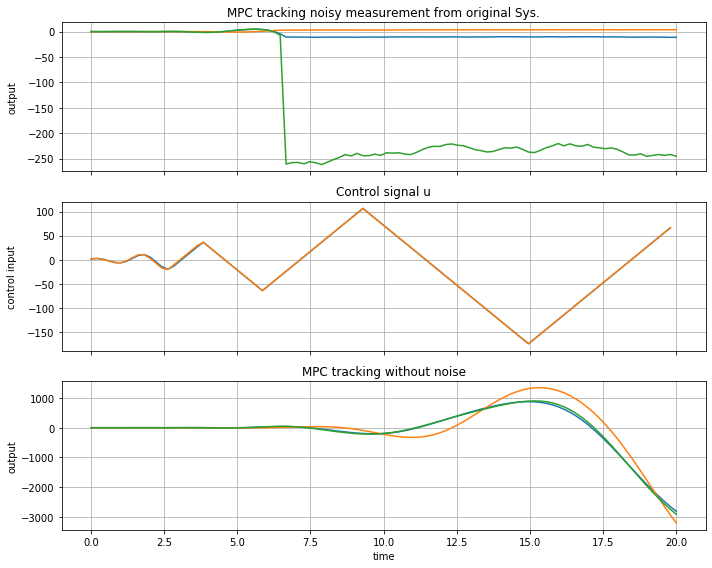

In [14]:
## results visualization ##
time = np.linspace(0, 20, num=100)

res_x_T = np.concatenate(res_x,axis=1)
res_u = np.array(res_u)
res_u = res_u.reshape(time.shape[0]-1,nu)

res_y = np.array(y_res)

y0 = np.zeros((ny,1))

res_y_withoutnoise = [y0]
for n in range(len(time)-1):
    temp = (Cb@res_x_T[:,n]).reshape(Cb.shape[0],1) + (Dr@res_u[n,:]).reshape(Cb.shape[0],1)
    res_y_withoutnoise.append(temp)
res_y_withoutnoise = np.array(res_y_withoutnoise).reshape(len(time),Cb.shape[0])


fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(time,res_y)
ax[0].set_title('MPC tracking noisy measurement from original Sys.')
ax[0].set_ylabel('output')
ax[0].grid()

ax[1].set_title('Control signal u')
ax[1].plot(time[:-1],res_u)
ax[1].set_ylabel('control input')
ax[1].grid()

ax[2].plot(time,res_y_withoutnoise)
ax[2].set_title('MPC tracking without noise')
ax[2].set_xlabel('time')
ax[2].set_ylabel('output')
ax[2].grid()

fig.align_ylabels()
fig.tight_layout()

plt.savefig('Step_response',dpi=250)

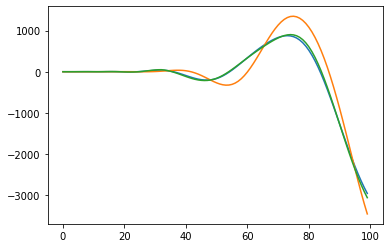

In [15]:
# test on model
res = (np.array(res_x)).reshape(N_sim,Ab.shape[0])

Y = []
for n in range(N_sim):
    y = Cb@res[n]
    Y.append(y)
Y = np.array(Y)
plt.plot(Y)